In [1]:
import numpy as np
import nibabel as nib
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
!pwd

/home/ltu/Desktop/project/scripts


In [3]:
people_list = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'P01', 'P02']

In [4]:
# load raw GRASE data
C03_GRASE=sio.loadmat(file_name='../raw_data/C03_GRASE.mat')
C04_GRASE=sio.loadmat(file_name='../raw_data/C04_GRASE.mat')
C05_GRASE=sio.loadmat(file_name='../raw_data/C05_GRASE.mat')
C06_GRASE=sio.loadmat(file_name='../raw_data/C06_GRASE.mat')
C07_GRASE=sio.loadmat(file_name='../raw_data/C07_GRASE.mat')
C08_GRASE=sio.loadmat(file_name='../raw_data/C08_GRASE.mat')
P01_GRASE=sio.loadmat(file_name='../raw_data/P01_GRASE.mat')
P02_GRASE=sio.loadmat(file_name='../raw_data/P02_GRASE.mat')


In [5]:
# load brain masks
C03_brain_mask = nib.load('../raw_data/C03_brain_mask.nii.gz')
C04_brain_mask = nib.load('../raw_data/C04_brain_mask.nii.gz')
C05_brain_mask = nib.load('../raw_data/C05_brain_mask.nii.gz')
C06_brain_mask = nib.load('../raw_data/C06_brain_mask.nii.gz')
C07_brain_mask = nib.load('../raw_data/C07_brain_mask.nii.gz')
C08_brain_mask = nib.load('../raw_data/C08_brain_mask.nii.gz')
P01_brain_mask = nib.load('../raw_data/P01_brain_mask.nii.gz')
P02_brain_mask = nib.load('../raw_data/P02_brain_mask.nii.gz')


In [6]:
# load nnls results
C03_NNLS=sio.loadmat(file_name='../raw_data/C03_kevin_moremaps.mat')
C04_NNLS=sio.loadmat(file_name='../raw_data/C04_kevin_moremaps.mat')
C05_NNLS=sio.loadmat(file_name='../raw_data/C05_kevin_moremaps.mat')
C06_NNLS=sio.loadmat(file_name='../raw_data/C06_kevin_moremaps.mat')
C07_NNLS=sio.loadmat(file_name='../raw_data/C07_kevin_moremaps.mat')
C08_NNLS=sio.loadmat(file_name='../raw_data/C08_kevin_moremaps.mat')
P01_NNLS=sio.loadmat(file_name='../raw_data/P01_kevin_moremaps.mat')
P02_NNLS=sio.loadmat(file_name='../raw_data/P02_kevin_moremaps.mat')

In [7]:
GRASE_list = [C03_GRASE, C04_GRASE, C05_GRASE, C06_GRASE, C07_GRASE, C08_GRASE, P01_GRASE, P02_GRASE]
brain_mask_list = [C03_brain_mask, C04_brain_mask, C05_brain_mask, C06_brain_mask, C07_brain_mask, C08_brain_mask, P01_brain_mask, P02_brain_mask]             
NNLS_list = [C03_NNLS, C04_NNLS, C05_NNLS, C06_NNLS, C07_NNLS, C08_NNLS, P01_NNLS, P02_NNLS]

In [8]:
def data_masked_4D(data,mask):
    mask[mask==0]='nan'
    mask_4D=np.tile(np.stack((mask,mask),axis=-1),[1,1,1,16]) # create 4th dimension with size 32
    data_masked = data*mask_4D
    return data_masked

In [9]:
def decay_extraction(data_masked):
    data_flat = data_masked.reshape(data_masked.shape[0]*data_masked.shape[1]*data_masked.shape[2],32)
    data_flat_strip = data_flat[~np.isnan(data_flat).any(axis=1)] # '~' is the logical_not operater
    return data_flat_strip

In [10]:
def MWF_extraction(data_masked):
    data_flat = data_masked.reshape(data_masked.shape[0]*data_masked.shape[1]*data_masked.shape[2],40) # changed to 40 so have 40 outputs per voxel
    data_flat_strip = data_flat[~np.isnan(data_flat).any(axis=1)] # '~' is the logical_not operater
    return data_flat_strip

for person, GRASE, brain_mask, NNLS in zip(people_list[:2], GRASE_list[:2], brain_mask_list[:2], NNLS_list[:2]):
    print(person)
    np.save('../' + person +'_preprocessed_data', brain_data_processed)

In [11]:
for person, GRASE, brain_mask, NNLS in zip(people_list, GRASE_list, brain_mask_list, NNLS_list):
    print(person)
    Data_raw=GRASE['scan']['image']
    Data_raw=np.array(list(Data_raw[0]), dtype=np.float).squeeze()
#    print('raw', Data_raw.shape)
    
    # make brain mask
    brain_mask = brain_mask.get_data()
    brain_mask = np.swapaxes(brain_mask,0,1)
    brain_mask = np.flip(brain_mask,0)
    brain_mask = brain_mask.astype(float)
    
 #   print('mask', brain_mask.shape)
    
    # apply brain mask
    brain_data_masked=data_masked_4D(Data_raw,brain_mask)
    
    # reshape MWI data
    brain_data_processed=decay_extraction(brain_data_masked)
    
 #   print('INPUT DATA', brain_data_processed.shape)
    
    # select relevant part of NNLS results
    labels = NNLS['distributions']
  #  print(labels.shape)
    
    MWF_NNLS_data=np.nan_to_num(labels)
    
    # apply brain mask to NNLS results
    brain_mask_nan = brain_mask
    brain_mask_nan[brain_mask_nan==0]='nan'
    brain_mask_nan = np.repeat(brain_mask_nan[:, :, :, np.newaxis], 40, axis=3)
    MWF_NNLS_brain_masked=MWF_NNLS_data*brain_mask_nan

    # reshape NNLS data
 #   print(MWF_NNLS_brain_masked.shape)
   
    MWF_NNLS_brain_flat_strip = MWF_extraction(MWF_NNLS_brain_masked)
#    print(MWF_NNLS_brain_flat_strip)
    
    # normalize labels
    sum_labels = np.sum(MWF_NNLS_brain_flat_strip, axis=1)
    sum_labels_nozeros = sum_labels[sum_labels != 0]
    MWF_NNLS_brain_flat_strip_nonzeros = MWF_NNLS_brain_flat_strip[sum_labels != 0]
    print(MWF_NNLS_brain_flat_strip.shape)
    print(MWF_NNLS_brain_flat_strip_nonzeros.shape)
  #  print(sum_labels)
    norm_labels = MWF_NNLS_brain_flat_strip_nonzeros / sum_labels_nozeros[:, np.newaxis]
    print(brain_data_processed.shape)
    brain_data_processed_nonzeros = brain_data_processed[sum_labels!=0]
    print(brain_data_processed_nonzeros.shape)
 #   print(norm_labels.shape)
 #   print(norm_labels[0])
 #   print(sum(norm_labels[0]))
    
#    print('LABELS', MWF_NNLS_brain_flat_strip.shape)
#    print('saving...')
    np.save('../preprocessed_data/' + person + '_preprocessed_data', brain_data_processed_nonzeros)
    np.save('../preprocessed_data/' + person +'_labels', norm_labels)
    print('*************')
    
   

C03


/home/ltu/.conda/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


(599140, 40)
(597166, 40)
(599140, 32)
(597166, 32)
*************
C04
(532874, 40)
(530304, 40)
(532874, 32)
(530304, 32)
*************
C05
(620991, 40)
(617882, 40)
(620991, 32)
(617882, 32)
*************
C06
(708429, 40)
(706009, 40)
(708429, 32)
(706009, 32)
*************
C07
(562384, 40)
(559513, 40)
(562384, 32)
(559513, 32)
*************
C08
(619981, 40)
(618312, 40)
(619981, 32)
(618312, 32)
*************
P01
(595633, 40)
(595045, 40)
(595633, 32)
(595045, 32)
*************
P02
(527538, 40)
(524977, 40)
(527538, 32)
(524977, 32)
*************


In [23]:
print(norm_labels[1])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]


In [76]:
for person, GRASE, brain_mask, NNLS in zip(people_list, GRASE_list, brain_mask_list, NNLS_list):
    print(person)
    Data_raw=GRASE['scan']['image']
    Data_raw=np.array(list(Data_raw[0]), dtype=np.float).squeeze()
    print('raw', Data_raw.shape)
    
    # make brain mask
    brain_mask = brain_mask.get_data()
    brain_mask = np.swapaxes(brain_mask,0,1)
    brain_mask = np.flip(brain_mask,0)
    brain_mask = brain_mask.astype(float)
    
    print('mask', brain_mask.shape)
    
    # apply brain mask
    brain_data_masked=data_masked_4D(Data_raw,brain_mask)
    
    # reshape MWI data
    brain_data_processed=decay_extraction(brain_data_masked)
    
    print('INPUT DATA', brain_data_processed.shape)
    
    # select relevant part of NNLS results
    labels = NNLS['distributions']
  #  print(labels.shape)
    
    MWF_NNLS_data=np.nan_to_num(labels)
    
    # apply brain mask to NNLS results
    brain_mask_nan = brain_mask
    brain_mask_nan[brain_mask_nan==0]='nan'
    brain_mask_nan = np.repeat(brain_mask_nan[:, :, :, np.newaxis], 40, axis=3)
    MWF_NNLS_brain_masked=MWF_NNLS_data*brain_mask_nan

    # reshape NNLS data
 #   print(MWF_NNLS_brain_masked.shape)
    MWF_NNLS_brain_flat_strip = MWF_extraction(MWF_NNLS_brain_masked)
    print('LABELS', MWF_NNLS_brain_flat_strip.shape)
   
    print('saving...')
    np.save('../preprocessed_data/' + person + '_preprocessed_data', brain_data_processed)
    np.save('../preprocessed_data/' + person +'_labels', MWF_NNLS_brain_flat_strip)
    print('*************')
    

C03
raw (240, 240, 40, 32)
mask (240, 240, 40)


/home/ltu/.conda/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


INPUT DATA (599140, 32)
LABELS (599140, 40)
saving...
*************
C04
raw (240, 240, 40, 32)
mask (240, 240, 40)
INPUT DATA (532874, 32)
LABELS (532874, 40)
saving...
*************
C05
raw (240, 240, 40, 32)
mask (240, 240, 40)
INPUT DATA (620991, 32)
LABELS (620991, 40)
saving...
*************
C06
raw (240, 240, 40, 32)
mask (240, 240, 40)
INPUT DATA (708429, 32)
LABELS (708429, 40)
saving...
*************
C07
raw (240, 240, 40, 32)
mask (240, 240, 40)
INPUT DATA (562384, 32)
LABELS (562384, 40)
saving...
*************
C08
raw (240, 240, 40, 32)
mask (240, 240, 40)
INPUT DATA (619981, 32)
LABELS (619981, 40)
saving...
*************
P01
raw (240, 240, 40, 32)
mask (240, 240, 40)
INPUT DATA (595633, 32)
LABELS (595633, 40)
saving...
*************
P02
raw (240, 240, 40, 32)
mask (240, 240, 40)
INPUT DATA (527538, 32)
LABELS (527538, 40)
saving...
*************


In [4]:
Data_raw=GRASE['scan']['image']
Data_raw=np.array(list(Data_raw[0]), dtype=np.float).squeeze()
Data_raw.shape

(240, 240, 40, 32)

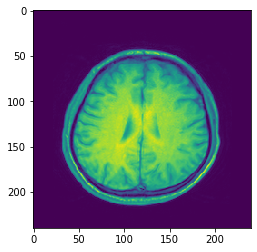

In [5]:
pic=Data_raw[:,:,20,0]
img = plt.imshow(pic)
#plt.rcParams['figure.dpi'] = plt.rcParamsDefault['figure.dpi']*2
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [6]:
brain_mask = nib.load('/data/workgroup/SCI/SCI_CS_data/SCI_PAIN_C04/HEAD/analysis/brain_mask.nii.gz')



/home/ltu/.conda/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [7]:
brain_mask = np.swapaxes(brain_mask,0,1)
brain_mask = np.flip(brain_mask,0)
#brain_mask = np.flip(brain_mask,1)

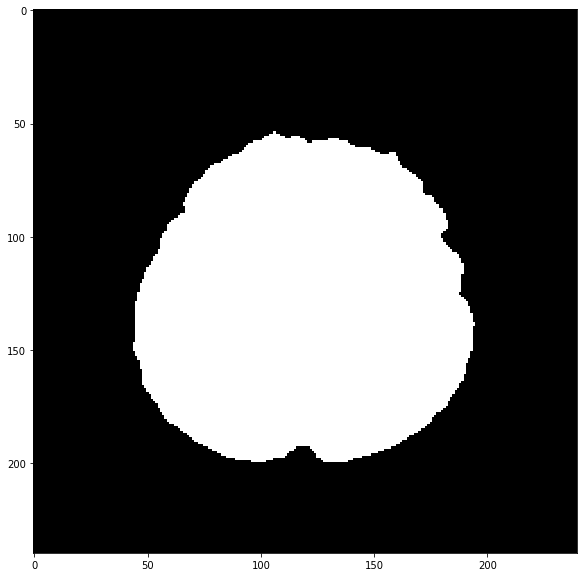

In [8]:
pic=brain_mask[:,:,20]
img = plt.imshow(pic)
#plt.rcParams['figure.dpi'] = plt.rcParamsDefault['figure.dpi']*2
#plt.rcParams['image.cmap'] = 'jet'
#plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [9]:
#brain_mask=np.array(brain_mask)
#type(brain_mask)
brain_mask= brain_mask.astype(float)

In [10]:
brain_mask.shape

(240, 240, 40)

In [11]:
def data_masked_4D(data,mask):
    mask[mask==0]='nan'
    mask_4D=np.tile(np.stack((mask,mask),axis=-1),[1,1,1,16]) # create 4th dimension with size 32
    data_masked = data*mask_4D
    return data_masked

In [12]:
brain_data_masked=data_masked_4D(Data_raw,brain_mask)

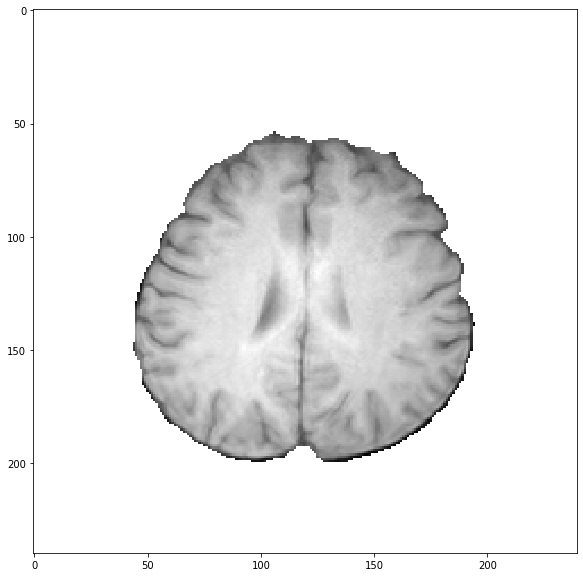

In [13]:
pic=brain_data_masked[:,:,20,0]
img = plt.imshow(pic)
#plt.rcParams['figure.dpi'] = plt.rcParamsDefault['figure.dpi']*2
#plt.rcParams['image.cmap'] = 'jet'
#plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [14]:
def slice_decay_extraction(slice_num,data_masked):
    slice_data = data_masked[:,:,slice_num,:]
    slice_data_flat = slice_data.reshape(data_masked.shape[0]*data_masked.shape[1],32)
    slice_data_flat_strip = slice_data_flat[~np.isnan(slice_data_flat).any(axis=1)] # '~' is the logical_not operater
    return slice_data_flat_strip

In [15]:
def decay_extraction(data_masked):
    data_flat = data_masked.reshape(data_masked.shape[0]*data_masked.shape[1]*data_masked.shape[2],32)
    data_flat_strip = data_flat[~np.isnan(data_flat).any(axis=1)] # '~' is the logical_not operater
    return data_flat_strip

In [16]:
brain_data_processed=decay_extraction(brain_data_masked)
#np.random.shuffle(brain_data_processed) # shuffle the data to avoid regional bias

In [17]:
brain_data_processed.shape

(532874, 32)

In [18]:
brain_data_processed[10000]

array([424., 467., 401., 448., 422., 436., 420., 412., 406., 407., 395.,
       414., 402., 410., 385., 397., 389., 387., 390., 386., 387., 383.,
       376., 372., 367., 368., 366., 366., 363., 361., 357., 358.])

# labels

In [19]:
NNLS=sio.loadmat(file_name='../raw_data/C04_kevin_moremaps.mat')

In [20]:
NNLS['distributions']

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [21]:
labels = NNLS['distributions'][:,:,:,:]
#shape is (240, 240, 40, 40) but the last column is another view/angle of brain

In [22]:
labels.shape

(240, 240, 40, 40)

In [23]:
#MWF_NNLS_data=labels.get_data()
MWF_NNLS_data=np.nan_to_num(labels)
MWF_NNLS_data.shape

(240, 240, 40, 40)

In [23]:
#MWF_NNLS_data = np.swapaxes(MWF_NNLS_data,0,1)
#MWF_NNLS_data = np.flip(MWF_NNLS_data,0)
#MWF_NNLS_data = np.flip(MWF_NNLS_data,1)

In [24]:
MWF_NNLS_data.shape

(240, 240, 40, 40)

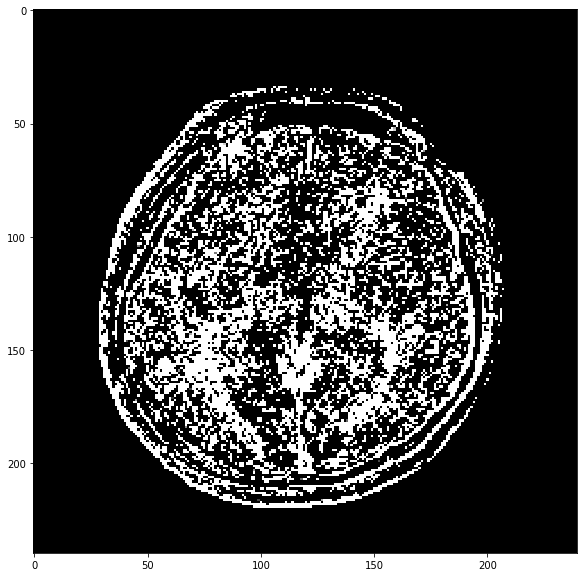

In [25]:
pic=MWF_NNLS_data[:,:,10,0]
img = plt.imshow(pic, vmin=0, vmax=0.5)
#plt.rcParams['figure.dpi'] = plt.rcParamsDefault['figure.dpi']*2
plt.rcParams['image.cmap'] = 'gray'
#plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [26]:
brain_mask_nan = brain_mask
brain_mask_nan[brain_mask_nan==0]='nan'
brain_mask_nan = np.repeat(brain_mask_nan[:, :, :, np.newaxis], 40, axis=3)
MWF_NNLS_brain_masked=MWF_NNLS_data*brain_mask_nan

In [27]:
MWF_NNLS_brain_masked.shape

(240, 240, 40, 40)

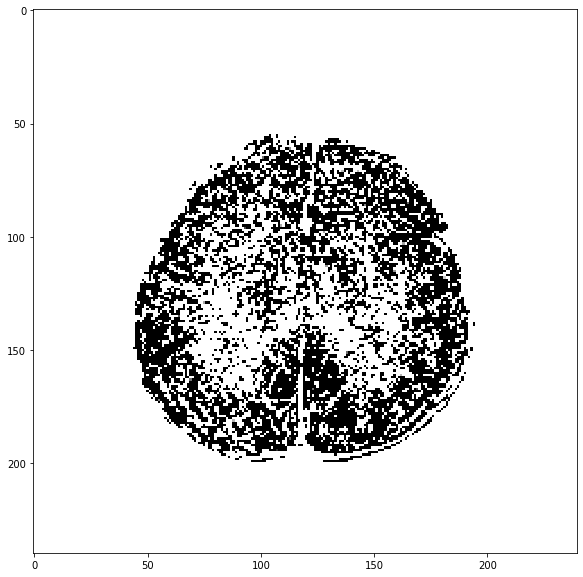

In [28]:
pic=MWF_NNLS_brain_masked[:,:,20,0]
img = plt.imshow(pic, vmin=0, vmax=0.5)
#plt.rcParams['figure.dpi'] = plt.rcParamsDefault['figure.dpi']*2
#plt.rcParams['image.cmap'] = 'jet'
#plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

def MWF_slice_extraction(slice_num,data_masked):
    slice_data = data_masked[:,:,slice_num]
    slice_data_flat = slice_data.reshape(data_masked.shape[0]*data_masked.shape[1],40) # changed to 40 so have 40 outputs per voxel
    slice_data_flat_strip = slice_data_flat[~np.isnan(slice_data_flat).any(axis=1)] # '~' is the logical_not operater
    return slice_data_flat_strip

In [29]:
def MWF_extraction(data_masked):
    data_flat = data_masked.reshape(data_masked.shape[0]*data_masked.shape[1]*data_masked.shape[2],40) # changed to 40 so have 40 outputs per voxel
    data_flat_strip = data_flat[~np.isnan(data_flat).any(axis=1)] # '~' is the logical_not operater
    return data_flat_strip

In [30]:
print(MWF_NNLS_brain_masked.shape)
MWF_NNLS_brain_flat_strip = MWF_extraction(MWF_NNLS_brain_masked)
print(MWF_NNLS_brain_flat_strip.shape)
MWF_NNLS_brain_flat_strip

(240, 240, 40, 40)
(532874, 40)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 37.91521435,
        40.4458591 , 42.74001395],
       [ 0.        ,  0.        ,  0.        , ..., 42.80720481,
        44.98809391, 46.95065426],
       ...,
       [15.53418088, 15.52733757, 15.39561881, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [31]:

# ASSUME CONCAT DATA THEN LABELS

#GET DEM DATA
print(MWF_NNLS_brain_flat_strip[:,:32].shape)
#GET DEM LABELS
print(MWF_NNLS_brain_flat_strip[:,32:].shape)

(599140, 32)
(599140, 8)


In [32]:
MWF_NNLS_brain_masked.shape

(240, 240, 40, 40)

In [33]:
brain_data_processed.shape

(599140, 32)

In [34]:
NNLS

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Oct 17 15:45:43 2018',
 '__version__': '1.0',
 '__globals__': [],
 'maps': array([[(array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan,

In [33]:
np.save('../preprocessed_data/data', brain_data_processed)